In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import cv2

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.utils import make_grid
from IPython.display import HTML


In [2]:
MANUAL_SEED = 42

torch.manual_seed(MANUAL_SEED)
print(f'Random Seed: {MANUAL_SEED}')

Random Seed: 42


In [3]:
data_color_root = 'C:/Datasets/Celeba/sample'
data_grayscale_root = 'C:/Datasets/Celeba/grayscale'
workers = 0 
batch_size = 10
image_size = 512
crop = 256
nc = 3
ngf = 64            # Number of features depth propagate through the generator,
ndf = 64            # Number of features depth propagate through the discriminator.
num_epochs = 5
lr = 2e-4
beta1 = 0.5         # beta1 hyperparameter for Adam optimizer.
ngpu = 1            # Number of GPUs.

In [4]:
is_cuda_available = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

## Data for Train the Generator and Discriminator

In [5]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=T.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]
            imgs = [np.uint8(img) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs
        

In [6]:
tf_rgb = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.CenterCrop(size=crop),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

tf_gray = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.CenterCrop(size=crop),
    T.ToTensor(),
    T.Normalize(mean=[.5], std=[.5])
])

tf_ab = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.CenterCrop(size=crop),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5], std=[.5, .5])
])

print(tf_rgb, tf_gray, tf_ab, sep='\n\n')

Compose(
    ToPILImage()
    Resize(size=512, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

Compose(
    ToPILImage()
    Resize(size=512, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

Compose(
    ToPILImage()
    Resize(size=512, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.5, 0.5], std=[0.5, 0.5])
)


In [7]:
# Load grayscale dataset.
gray_dataset = ImageDataset(path=data_grayscale_root, code=cv2.COLOR_BGR2GRAY, transform=tf_gray)
# Load color images with RGB color space.
rgb_dataset = ImageDataset(path=data_color_root, code=cv2.COLOR_BGR2RGB, transform=tf_rgb)
# Load LAB color space images.
lab_dataset = ImageDataset(path=data_color_root, code=cv2.COLOR_BGR2LAB, transform=tf_rgb)

In [8]:
gray_loader = DataLoader(dataset=gray_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
rgb_loader = DataLoader(dataset=rgb_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
lab_loader = DataLoader(dataset=lab_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)
l_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, '"LAB" COLOR CHANNELS OF LAB SAMPLE')

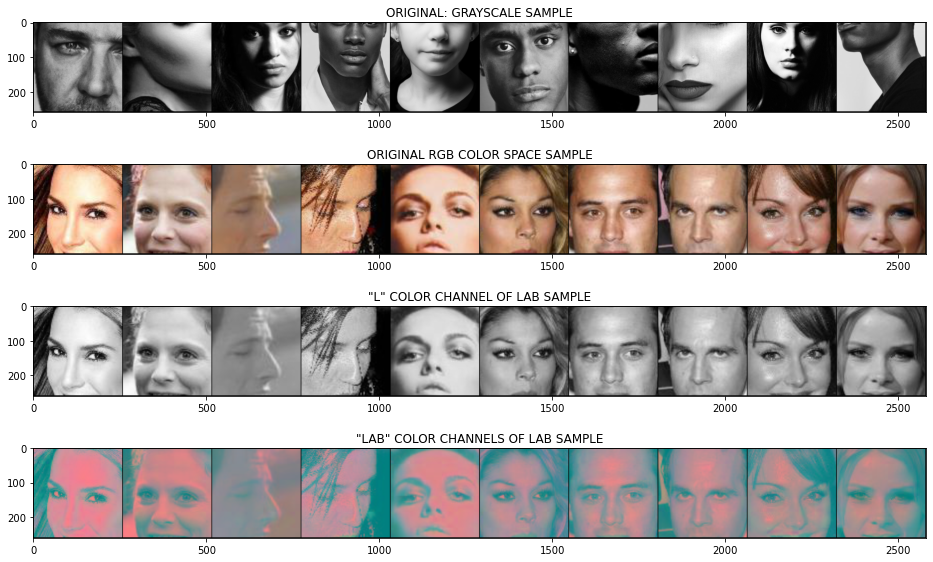

In [9]:
FIG_SIZE = (16, 10)

gray_batch1 = next(iter(gray_loader))
rgb_batch1 = next(iter(rgb_loader))
lab_batch1 = next(iter(lab_loader))
l_batch1 = next(iter(l_loader))

im_gray = make_grid(gray_batch1, nrow=10, normalize=True)
im_rgb = make_grid(rgb_batch1, nrow=10, normalize=True)
im_lab = make_grid(lab_batch1, nrow=10, normalize=True)
im_l = make_grid(l_batch1, nrow=10, normalize=True)

plt.figure(figsize=FIG_SIZE)

# Original grayscale images grid.
plt.subplot(411)
plt.imshow(np.transpose(im_gray, axes=(1, 2, 0)))
plt.title('ORIGINAL: GRAYSCALE SAMPLE')

# Original RGB images grid.
plt.subplot(412)
plt.imshow(np.transpose(im_rgb, axes=(1, 2, 0)))
plt.title('ORIGINAL RGB COLOR SPACE SAMPLE')

# L color channel of LAB color space.
plt.subplot(413)
plt.imshow(np.transpose(im_l, axes=(1, 2, 0)))
plt.title('"L" COLOR CHANNEL OF LAB SAMPLE')

# AB color channels of LAB color space.
plt.subplot(414)
plt.imshow(np.transpose(im_lab, axes=(1, 2, 0)))
plt.title('"LAB" COLOR CHANNELS OF LAB SAMPLE')


## Weight Initialization for the Layer of Both of the Discriminator and Generator Models

In [10]:
def weight_init(m):

    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0., std=0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1., std=0.2)
        nn.init.constant_(m.bias.data, val=0.)
        

In [28]:
class Generator(nn.Module):

    def __init__(self, nz=1):
        super(Generator, self).__init__()

        # Encoding/Contracting Layers.
        self.e_conv1 = nn.Conv2d(in_channels=nz, out_channels=ngf, kernel_size=1, stride=1)
        self.e_conv2 = nn.Conv2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1)
        self.e_conv3 = nn.Conv2d(in_channels=ngf, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1)
        self.e_conv4 = nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1)
        self.e_conv5 = nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.e_conv6 = nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.e_conv7 = nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.e_conv8 = nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.e_conv9 = nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)

        # Decode/Expansive Layers.
        self.d_conv1 = nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2)
        self.d_conv2 = nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.d_conv3 = nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1)
        self.d_conv4 = nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1)
        self.d_conv5 = nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1)
        self.d_conv6 = nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1)
        self.d_conv7 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, padding=1)
        # cross-channel parametric pooling layer.
        self.d_conv8 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=1, stride=1)

        self.batchnorm64 = nn.BatchNorm2d(ngf)
        self.batchnorm128 = nn.BatchNorm2d(ngf * 2)
        self.batchnorm256 = nn.BatchNorm2d(ngf * 4)
        self.batchnorm512 = nn.BatchNorm2d(ngf * 8)
        # self.batchnorm1024 = nn.BatchNorm2d(ngf * 16)
        # self.batchnorm2048 = nn.BatchNorm2d(ngf * 32)

    def forward(self, X):
        # Feed forward to contraction.
        co1 = F.leaky_relu(self.batchnorm64(self.e_conv1(X)), negative_slope=0.2)
        co2 = F.leaky_relu(self.batchnorm64(self.e_conv2(co1)), negative_slope=0.2)
        co3 = F.leaky_relu(self.batchnorm128(self.e_conv3(co2)), negative_slope=0.2)
        co4 = F.leaky_relu(self.batchnorm256(self.e_conv4(co3)), negative_slope=0.2)
        co5 = F.leaky_relu(self.batchnorm512(self.e_conv5(co4)), negative_slope=0.2)
        co6 = F.leaky_relu(self.batchnorm512(self.e_conv6(co5)), negative_slope=0.2)
        co7 = F.leaky_relu(self.batchnorm512(self.e_conv7(co6)), negative_slope=0.2)
        co8 = F.leaky_relu(self.batchnorm512(self.e_conv8(co7)), negative_slope=0.2)
        out = F.leaky_relu(self.batchnorm512(self.e_conv9(co8)), negative_slope=0.2)

        out = torch.add(co7, F.leaky_relu(self.batchnorm512(self.d_conv1(out)), negative_slope=0.2))
        out = torch.add(co6, F.leaky_relu(self.batchnorm512(self.d_conv2(out)), negative_slope=0.2))
        out = torch.add(co5, F.leaky_relu(self.batchnorm512(self.d_conv3(out)), negative_slope=0.2))
        out = torch.add(co4, F.leaky_relu(self.batchnorm256(self.d_conv4(out)), negative_slope=0.2))
        out = torch.add(co3, F.leaky_relu(self.batchnorm128(self.d_conv5(out)), negative_slope=0.2))
        out = torch.add(co2, F.leaky_relu(self.batchnorm64(self.d_conv6(out)), negative_slope=0.2))
        out = torch.add(co1, F.leaky_relu(self.batchnorm64(self.d_conv7(out)), negative_slope=0.2))
        out = F.tanh(self.d_conv8(out))

        return out

# Create the generator(G) model instance.
netG = Generator().to(device)
netG = netG.apply(weight_init)
netG


Generator(
  (e_conv1): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (e_conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv7): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv8): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e_conv9): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2))
  (d_conv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (d_conv4): ConvTranspose2d

In [27]:
X = torch.ones(10, 1, 256, 256, device=device)

y = netG(X)
print(y.shape)

torch.Size([10, 3, 256, 256])


In [ ]:
with torch.no_grad():
    X = torch.ones(10, 1, 256, 256, device=device)

    y = netG(X)
    print(y.shape)

im = make_grid(y.detach().cpu(), nrow=10, normalize=True)
im = np.transpose(im.numpy() * 255, axes=(1, 2, 0)).astype(np.uint8)

plt.figure(figsize=(12, 11))
plt.imshow(cv2.cvtColor(im, code=cv2.COLOR_LAB2RGB))

In [29]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 256 x 256
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=1, stride=1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf) x 256 x 256
            nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf) x 128 x 128
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 2) x 64 x 64
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 4) x 32 x 32
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 8) x 16 x 16
            nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 8) x 8 x 8
            nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # State size => (ndf * 8) x 2 x 2
            nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
            # State size => (ndf * 8) x 1 x 1
        )

    def forward(self, input):
        return self.main(input)


# Create discriminator(D) model instance.
netD = Discriminator().to(device)
netD = netD.apply(weight_init)
netD


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, 

In [16]:
X = torch.ones(10, 3, 256, 256, device=device)

y = netD(X).view(-1)
y.shape

torch.Size([10])

In [30]:
# Enable parallel process over GPUs, if desired (When ngpu == 1, do not occur parallel execution, since there is only one GPU);
if device.type == 'cuda' and ngpu >= 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

print(netG, netD, sep='\n\n')

DataParallel(
  (module): Generator(
    (e_conv1): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (e_conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv7): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv8): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (e_conv9): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (d_conv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2))
    (d_conv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (d_conv3): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2

## Loss Function and Optimizers

In [31]:
# Initializing "Binary Cross Entropy" loss function.
criterion = nn.BCELoss().to(device)

# Initializing "Adam" optimizers for both G and D networks.
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=100)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=100)

In [32]:
# Establish convention for the real and fake images during training.
real_labels = 1
fake_labels = 0

## Training

In [33]:
img_list = []
G_losses = []
D_losses = []

iters = 0

print("Starting training loop...")

start = time.time()

for epoch in range(num_epochs):
    epoch += 1

    for batch, (lab_images, l_images) in enumerate(zip(lab_loader, l_loader), 0):
        batch += 1

        # ###################################################################
        # Train the D network. Maximize the ability to classify real and fake 
        # images.
        # ###################################################################

        ############## Train with all real image batch ######################
        netD.zero_grad()
        # Create label batch to check the loss with real images.
        lab_images.to(device)
        l_images.to(device)

        batch_size = lab_images.shape[0]
        labels = torch.full(size=(batch_size, ), fill_value=real_labels, dtype=torch.float32, device=device)

        # Feed forward real batch through D.
        y = netD(lab_images).view(-1)
        # Loss calculation on all real batch.
        errD_real = criterion(y, labels)

        # Calculate the gradient for the D in back-propagation.
        errD_real.backward()
        D_x = y.mean().item()

        ############ Train with all grayscale image batch ###################

        # Generate fake image batch with G.
        fake = netG(l_images)
        labels.fill_(fake_labels)

        # Classify all fake image images with D. 'detach()' the 'fake' to avoid leaking G gradient to D.
        y = netD(fake.detach()).view(-1)

        # Calculate D loss for all fake images.
        errD_fake = criterion(y, labels)

        # Calculate the the gradient for fake batch in back-propagation.
        errD_fake.backward()
        D_G_z1 = y.mean().item()

        # Calculate total gradient to real and fake images for D.
        errD = errD_real + errD_fake

        # Update D.
        optimizerD.step()

        # ###################################################################
        # Train the G network. Minimize the ability of creating fake images.
        # ###################################################################

        netG.zero_grad()

        labels.fill_(real_labels) # Fake images are real of G's perspective.

        # Since we just updated the D, feed forward the batch of fake images 
        # without 'detach()' the gradient from the G. So, we could literally 
        # discriminate the G's previous output.
        y = netD(fake).view(-1)

        # Calculate G's loss base off this output.
        errG = criterion(y, labels)

        # Calculate gradient for the G.
        errG.backward()
        D_G_z2 = errG.mean().item()

        # Update generator.
        optimizerG.step()

        # OUTPUT TRAINING STATS.
        if batch == 1 or batch % 100 == 0:
            print("[{}/{}] [{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}/{:.4f}"
                .format(epoch, num_epochs, batch, len(lab_loader), errD, errG, D_x, D_G_z1, D_G_z2))
            
        D_losses.append(errD)
        G_losses.append(errG)

        # Check how the G is doing by saving the G's output on fixed noise.
        if iters % 500 == 0 or ((epoch == num_epochs) and (batch == len(l_loader))):
            with torch.no_grad():
                fake = netG(l_images).detach().cpu()
            
            img_list.append(make_grid(fake, nrow=10, normalize=True))

        iters += 1


duration = time.time() - start
print(f"Execution Duration: {duration / 60:0.4f} minutes")

Starting training loop...
[1/5] [1/2000]	Loss_D: 4.2370	Loss_G: 4.2409	D(x): 0.5166	D(G(z)): 0.5018/4.2409
[1/5] [100/2000]	Loss_D: 5.5659	Loss_G: 3.3913	D(x): 0.3174	D(G(z)): 0.3983/3.3913
[1/5] [200/2000]	Loss_D: 2.9620	Loss_G: 2.6808	D(x): 0.5202	D(G(z)): 0.3861/2.6808
[1/5] [300/2000]	Loss_D: 2.0433	Loss_G: 2.2356	D(x): 0.5188	D(G(z)): 0.3020/2.2356
[1/5] [400/2000]	Loss_D: 3.8018	Loss_G: 2.2047	D(x): 0.4014	D(G(z)): 0.5714/2.2047
[1/5] [500/2000]	Loss_D: 2.4219	Loss_G: 1.8002	D(x): 0.5109	D(G(z)): 0.4326/1.8002
[1/5] [600/2000]	Loss_D: 2.1023	Loss_G: 1.7875	D(x): 0.5335	D(G(z)): 0.3305/1.7875
[1/5] [700/2000]	Loss_D: 2.4405	Loss_G: 1.3069	D(x): 0.4810	D(G(z)): 0.5239/1.3069
[1/5] [800/2000]	Loss_D: 2.4950	Loss_G: 1.8594	D(x): 0.4378	D(G(z)): 0.5093/1.8594
[1/5] [900/2000]	Loss_D: 2.1099	Loss_G: 1.8411	D(x): 0.4810	D(G(z)): 0.2976/1.8411
[1/5] [1000/2000]	Loss_D: 1.7219	Loss_G: 1.1377	D(x): 0.5245	D(G(z)): 0.4419/1.1377
[1/5] [1100/2000]	Loss_D: 1.1709	Loss_G: 1.3492	D(x): 0.5877	D

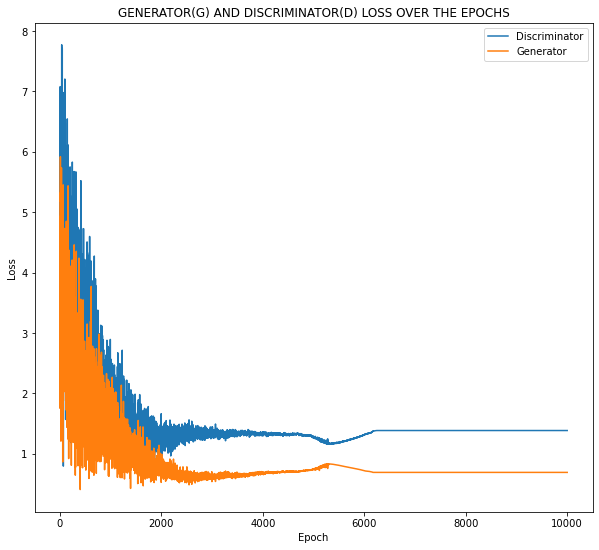

In [60]:
plt.figure(figsize=(10, 9))
plt.title('GENERATOR(G) AND DISCRIMINATOR(D) LOSS OVER THE EPOCHS')
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [61]:
torch.save(netG.state_dict(), '../state_dict/net_g_stat_dict.pth')

In [121]:
@torch.no_grad()
def lab_to_rgb(im):

    netG.eval()

    lab = netG(im).cpu()
    lab = lab.numpy() * 255

    lab = np.transpose(lab[0], (1, 2, 0)).astype(np.uint8)

    return cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)


In [136]:
@torch.no_grad()
def validate(img):

    netG.eval()

    lab = netG(img.to(device)).cpu()

    lab = lab.numpy() * 255

    lab = np.transpose(lab[0], axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    return lab

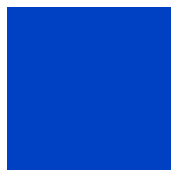

In [137]:
color = validate(l_batch1)

plt.figure(figsize=(4, 3))
plt.axis('off')
plt.imshow(color)